<a href="https://colab.research.google.com/github/anshita195/Data-Driven-Flight-Delay-Forecasting/blob/main/Anshita_Jain_Data_Driven_Flight_Delay_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error, mean_squared_error, confusion_matrix, roc_curve, auc, f1_score, make_scorer
from sklearn.multioutput import MultiOutputRegressor
import shap
from tqdm import tqdm  # For progress tracking
import warnings
warnings.filterwarnings('ignore')

1. Data Loading and Initial Inspection

In [ ]:
df = pd.read_csv('Airline_Delay_Cause.csv')
print(f"Initial data shape: {df.shape}")

Initial data shape: (179338, 21)


2. Data Preprocessing

In [ ]:
# Drop rows where 'arr_delay' is NaN
df.dropna(subset=['arr_delay'], inplace=True)
print(f"Shape after dropping rows with missing arr_delay: {df.shape}")

# Impute missing values
df['arr_flights'] = df['arr_flights'].fillna(df['arr_flights'].median())
delay_cols_to_impute_with_zero = [
    'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
    'arr_cancelled', 'arr_diverted', 'carrier_delay',
    'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'
]
for col in delay_cols_to_impute_with_zero:
    df[col] = df[col].fillna(0)

# Re-derive arr_del15
if 'arr_del15' in df.columns:
    df.drop(columns=['arr_del15'], inplace=True)
df['arr_del15'] = (df['arr_delay'] >= 15).astype(int)

# Outlier Treatment (Capping)
delay_duration_cols = [
    'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
    'security_delay', 'late_aircraft_delay'
]
for col in delay_duration_cols:
    upper_bound = df[col].quantile(0.99)
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

print("Data preprocessing complete.")

Shape after dropping rows with missing arr_delay: (178997, 21)
Data preprocessing complete.


3. Feature Engineering

In [ ]:
# Temporal Features
df['quarter'] = df['month'].apply(lambda x: (x-1)//3 + 1)
df['period'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2))

# Ratio Features
df['arr_flights_safe'] = df['arr_flights'].replace(0, np.nan)
df['cancelled_ratio'] = df['arr_cancelled'] / df['arr_flights_safe']
df['diverted_ratio'] = df['arr_diverted'] / df['arr_flights_safe']
df['cancelled_ratio'] = df['cancelled_ratio'].fillna(0)
df['diverted_ratio'] = df['diverted_ratio'].fillna(0)

# Delay Ratio Features
delay_cause_cols = [
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'
]
df['total_known_delay'] = df[delay_cause_cols].sum(axis=1)
df['total_known_delay_safe'] = df['total_known_delay'].replace(0, np.nan)

for col in delay_cause_cols:
    df[f'{col}_ratio'] = df[col] / df['total_known_delay_safe']
    df[f'{col}_ratio'] = df[f'{col}_ratio'].fillna(0)

# Target Encoding
def smoothed_target_encode(df_encode, category_col, target_col, alpha=100):
    global_mean = df_encode[target_col].mean()
    agg = df_encode.groupby(category_col)[target_col].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    encoded = (counts * means + alpha * global_mean) / (counts + alpha)
    return df_encode[category_col].map(encoded)

df['carrier_encoded_del15'] = smoothed_target_encode(df, 'carrier', 'arr_del15', alpha=100)
df['airport_encoded_del15'] = smoothed_target_encode(df, 'airport', 'arr_del15', alpha=100)
df['carrier_encoded_delay'] = smoothed_target_encode(df, 'carrier', 'arr_delay', alpha=100)
df['airport_encoded_delay'] = smoothed_target_encode(df, 'airport', 'arr_delay', alpha=100)

# Clean up temporary columns
df.drop(columns=['arr_flights_safe', 'total_known_delay', 'total_known_delay_safe'], inplace=True)
print("Feature engineering complete.")


Feature engineering complete.


 4. Exploratory Data Analysis (EDA) - Key Visualizations

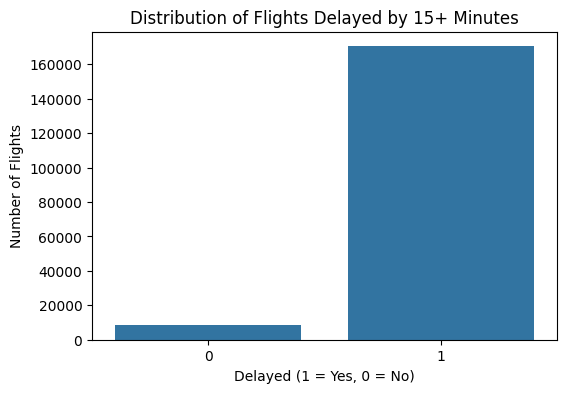

In [ ]:
# Distribution of arr_del15
plt.figure(figsize=(6, 4))
sns.countplot(x='arr_del15', data=df)
plt.title('Distribution of Flights Delayed by 15+ Minutes')
plt.xlabel('Delayed (1 = Yes, 0 = No)')
plt.ylabel('Number of Flights')
plt.savefig('arr_del15_distribution.png')
plt.show()

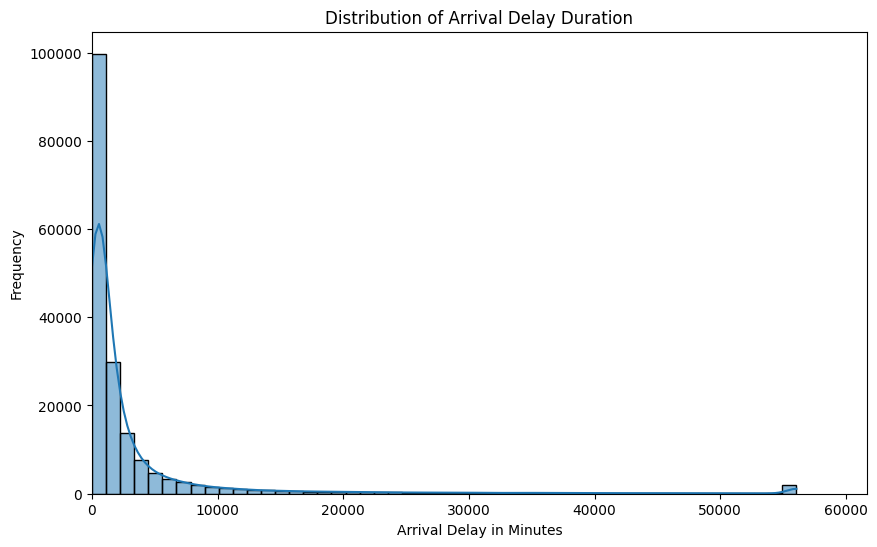

In [ ]:
# Distribution of arr_delay
plt.figure(figsize=(10, 6))
sns.histplot(df['arr_delay'], bins=50, kde=True)
plt.title('Distribution of Arrival Delay Duration')
plt.xlabel('Arrival Delay in Minutes')
plt.ylabel('Frequency')
plt.xlim(0, df['arr_delay'].quantile(0.99) * 1.1)
plt.savefig('arr_delay_distribution.png')
plt.show()

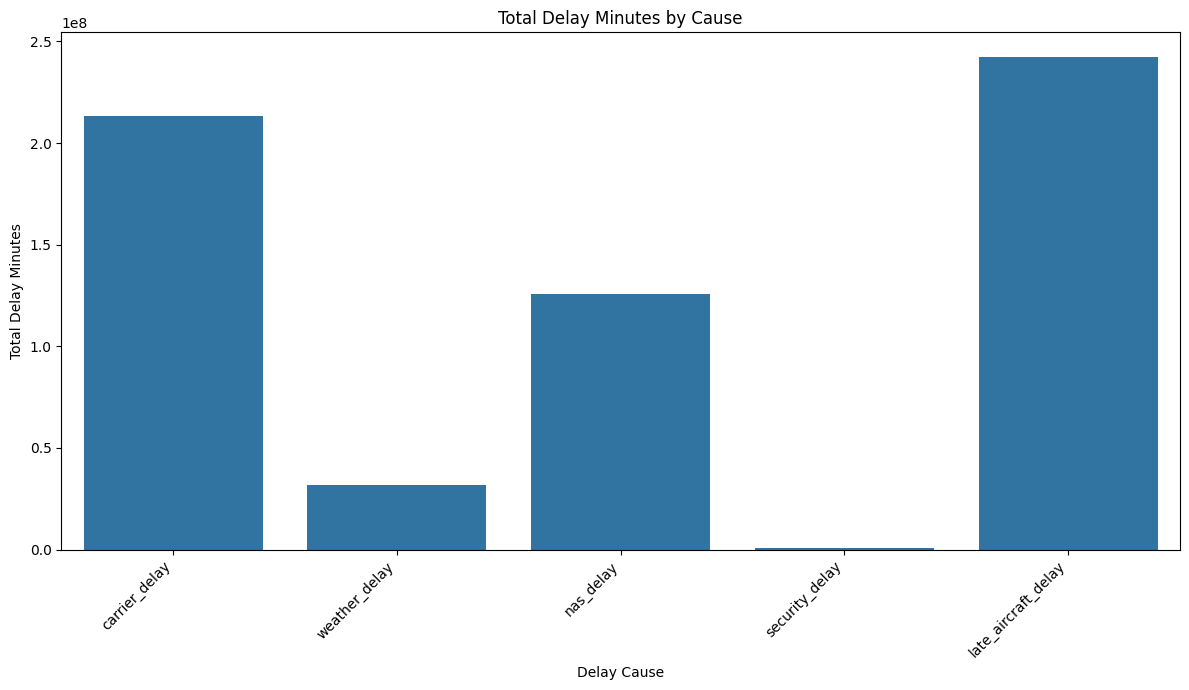

In [ ]:
# Total Delay Minutes by Cause
delay_minutes_cols = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
plt.figure(figsize=(12, 7))
sns.barplot(x=df[delay_minutes_cols].sum().index, y=df[delay_minutes_cols].sum().values)
plt.title('Total Delay Minutes by Cause')
plt.xlabel('Delay Cause')
plt.ylabel('Total Delay Minutes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('total_delay_minutes_by_cause.png')
plt.show()

5. Predictive Modeling

5.1 Classification Model

In [ ]:
X_clf = df.drop(columns=[
    'arr_del15', 'arr_delay',
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
    'arr_cancelled', 'arr_diverted',
    'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
    'cancelled_ratio', 'diverted_ratio',
    'carrier_delay_ratio', 'weather_delay_ratio', 'nas_delay_ratio',
    'security_delay_ratio', 'late_aircraft_delay_ratio',
    'year', 'month', 'period',
    'carrier', 'carrier_name', 'airport', 'airport_name',
    'carrier_encoded_delay', 'airport_encoded_delay'
])
y_clf = df['arr_del15']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

print("Training classification model...")
model_clf = RandomForestClassifier(n_estimators=30, random_state=42, class_weight='balanced', n_jobs=-1)
model_clf.fit(X_train_clf, y_train_clf)

y_pred_clf = model_clf.predict(X_test_clf)
y_pred_proba_clf = model_clf.predict_proba(X_test_clf)[:, 1]

print("Classification Report:\n", classification_report(y_test_clf, y_pred_clf))
print(f"AUC-ROC Score (Classification): {roc_auc_score(y_test_clf, y_pred_proba_clf):.4f}")


Training classification model...
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.45      0.46      1725
           1       0.97      0.98      0.97     34075

    accuracy                           0.95     35800
   macro avg       0.73      0.71      0.72     35800
weighted avg       0.95      0.95      0.95     35800

AUC-ROC Score (Classification): 0.8900


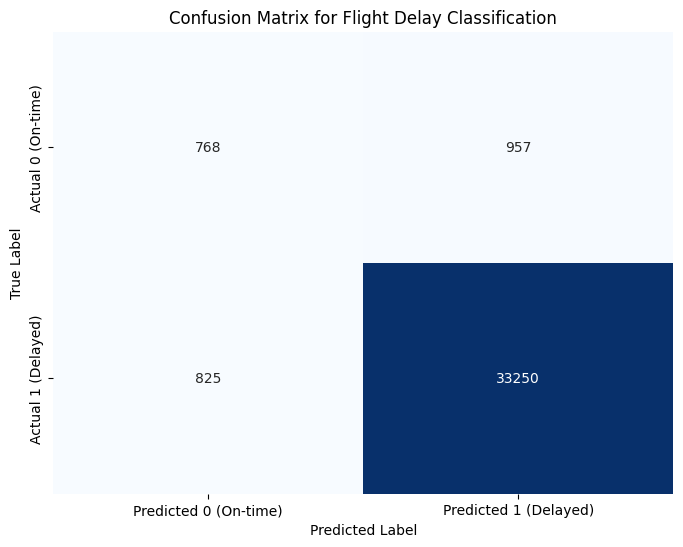

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0 (On-time)', 'Predicted 1 (Delayed)'],
            yticklabels=['Actual 0 (On-time)', 'Actual 1 (Delayed)'])
plt.title('Confusion Matrix for Flight Delay Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix_clf.png')
plt.show()

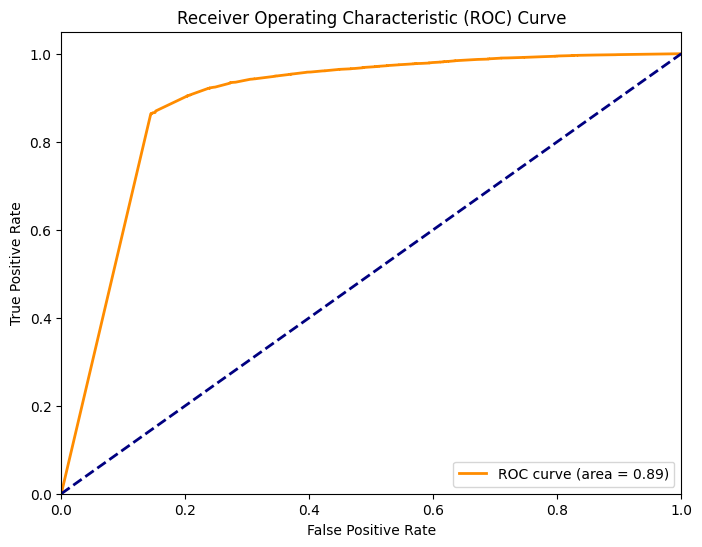

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_clf, y_pred_proba_clf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve_clf.png')
plt.show()

5.2 Regression Model

In [ ]:
X_reg = df.drop(columns=[
    'arr_del15', 'arr_delay',
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
    'year', 'month', 'period',
    'carrier', 'carrier_name', 'airport', 'airport_name',
    'carrier_encoded_del15', 'airport_encoded_del15'
])

y_reg_components = df[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg_components, test_size=0.2, random_state=42)

print("Training regression model...")
model_reg_multi = MultiOutputRegressor(RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1))
model_reg_multi.fit(X_train_reg, y_train_reg)

y_pred_reg_components = model_reg_multi.predict(X_test_reg)
y_pred_reg_components_df = pd.DataFrame(y_pred_reg_components, columns=y_reg_components.columns, index=X_test_reg.index)

print("\nEvaluation of Individual Delay Component Predictions:")
for col in y_reg_components.columns:
    mae_val = mean_absolute_error(y_test_reg[col], y_pred_reg_components_df[col])
    rmse_val = np.sqrt(mean_squared_error(y_test_reg[col], y_pred_reg_components_df[col]))
    print(f"  {col}: MAE={mae_val:.2f}, RMSE={rmse_val:.2f}")


Training regression model...

Evaluation of Individual Delay Component Predictions:
  carrier_delay: MAE=173.16, RMSE=394.94
  weather_delay: MAE=30.48, RMSE=90.65
  nas_delay: MAE=93.25, RMSE=279.31
  security_delay: MAE=0.92, RMSE=4.40
  late_aircraft_delay: MAE=169.58, RMSE=412.48


Operational Adjustability Index (OAI)

In [ ]:
oai_weights = {
    'carrier_delay': 2.0,
    'late_aircraft_delay': 2.0,
    'nas_delay': 1.0,
    'weather_delay': 0.5,
    'security_delay': 0.2
}

# Compute OAI per flight
y_test_reg_oai = (y_test_reg * pd.Series(oai_weights)).sum(axis=1)
y_pred_reg_oai = (y_pred_reg_components_df * pd.Series(oai_weights)).sum(axis=1)

# Normalize OAI to 0-100 range
min_oai = min(y_test_reg_oai.min(), y_pred_reg_oai.min())
max_oai = max(y_test_reg_oai.max(), y_pred_reg_oai.max())

y_test_reg_oai_scaled = 100 * (y_test_reg_oai - min_oai) / (max_oai - min_oai) if (max_oai - min_oai) != 0 else 0
y_pred_reg_oai_scaled = 100 * (y_pred_reg_oai - min_oai) / (max_oai - min_oai) if (max_oai - min_oai) != 0 else 0

print(f"Mean Predicted OAI Score (scaled 0-100): {np.mean(y_pred_reg_oai_scaled):.2f}")
print(f"Standard Deviation of Predicted OAI Score (scaled 0-100): {np.std(y_pred_reg_oai_scaled):.2f}")


Mean Predicted OAI Score (scaled 0-100): 6.06
Standard Deviation of Predicted OAI Score (scaled 0-100): 13.91


OAI Distribution & Reporting

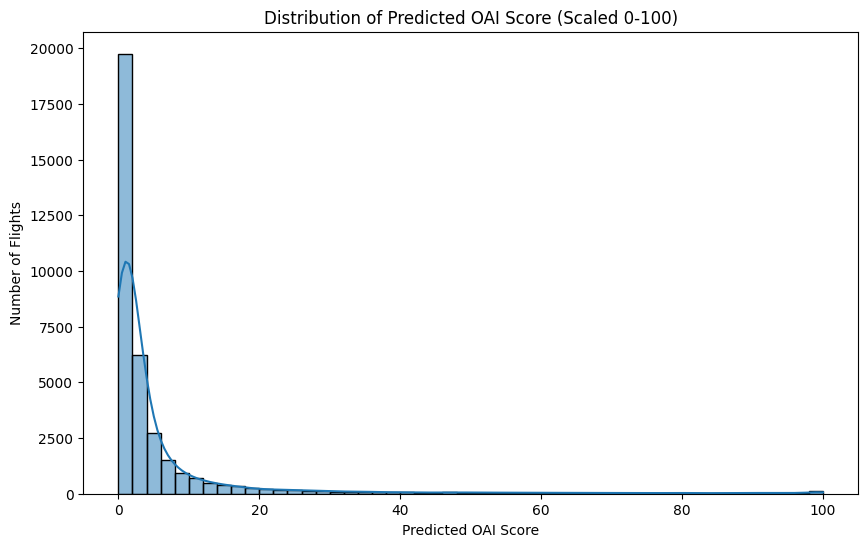

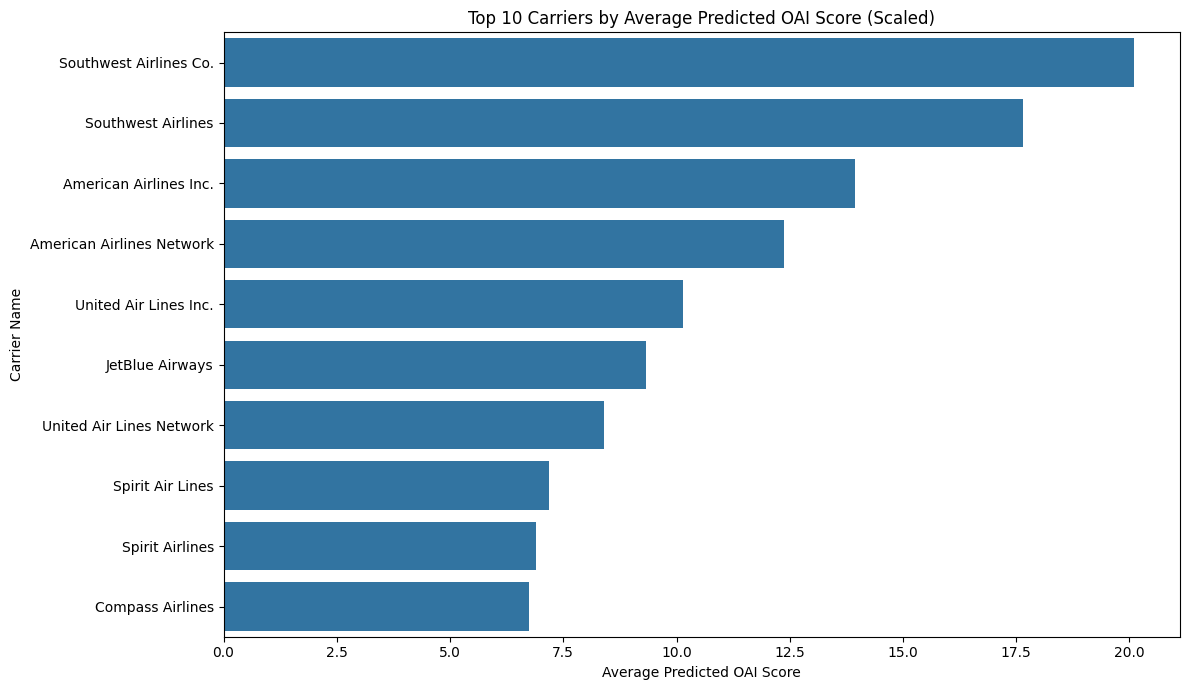

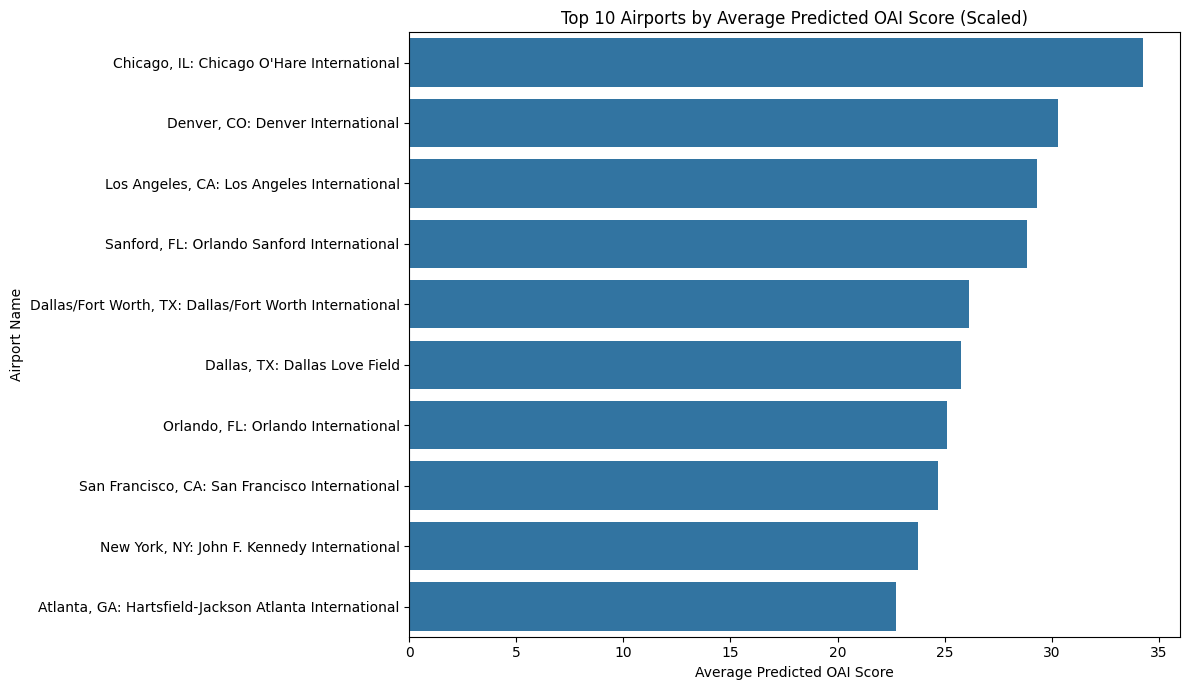

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_reg_oai_scaled, bins=50, kde=True)
plt.title('Distribution of Predicted OAI Score (Scaled 0-100)')
plt.xlabel('Predicted OAI Score')
plt.ylabel('Number of Flights')
plt.savefig('oai_distribution.png')
plt.show()

# Merge OAI with original data for carrier/airport analysis
oai_df = df.loc[y_pred_reg_components_df.index].copy()
oai_df['predicted_oai_score_scaled'] = y_pred_reg_oai_scaled

# Top 10 Carriers by Average Predicted OAI
oai_by_carrier = oai_df.groupby('carrier_name')['predicted_oai_score_scaled'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=oai_by_carrier.values, y=oai_by_carrier.index)
plt.title('Top 10 Carriers by Average Predicted OAI Score (Scaled)')
plt.xlabel('Average Predicted OAI Score')
plt.ylabel('Carrier Name')
plt.tight_layout()
plt.savefig('top_carriers_oai.png')
plt.show()

# Top 10 Airports by Average Predicted OAI
oai_by_airport = oai_df.groupby('airport_name')['predicted_oai_score_scaled'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=oai_by_airport.values, y=oai_by_airport.index)
plt.title('Top 10 Airports by Average Predicted OAI Score (Scaled)')
plt.xlabel('Average Predicted OAI Score')
plt.ylabel('Airport Name')
plt.tight_layout()
plt.savefig('top_airports_oai.png')
plt.show()

SHAP Analysis for Regression Components

Generating SHAP summary plot for: carrier_delay


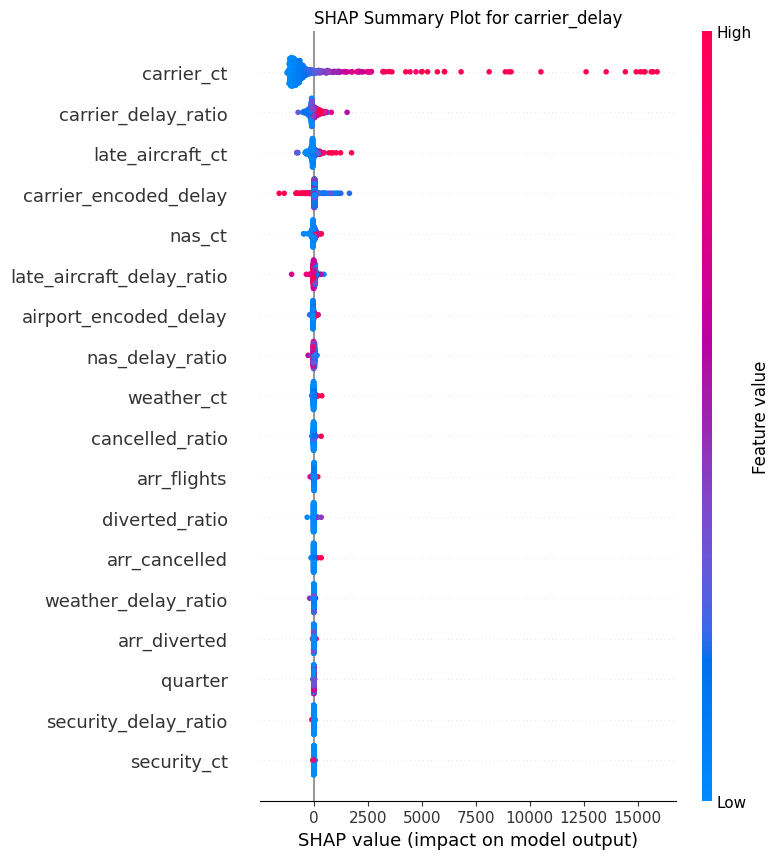

Generating SHAP summary plot for: weather_delay


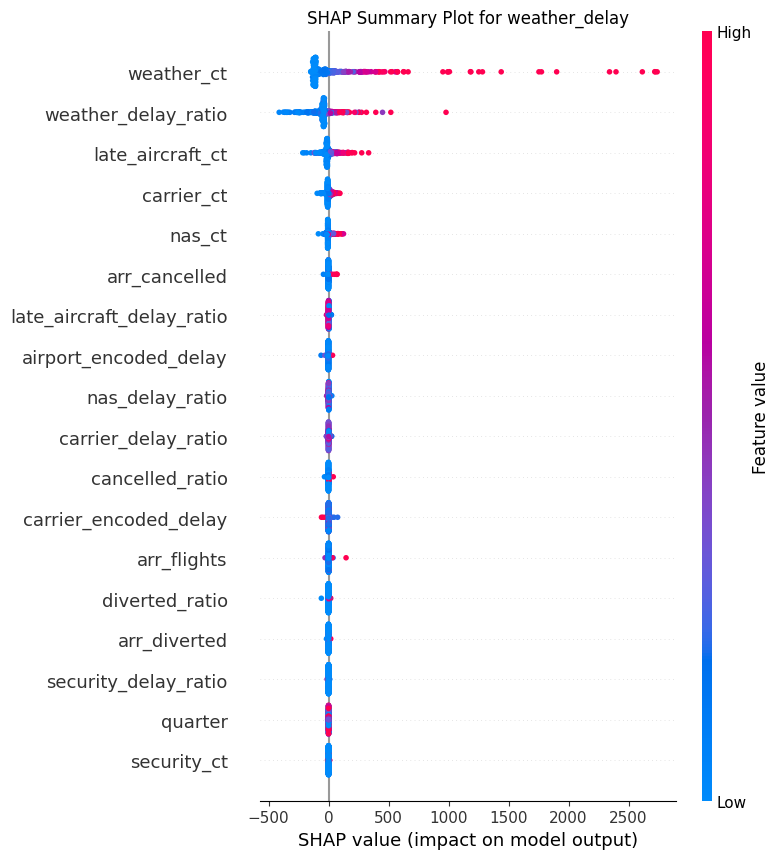

Generating SHAP summary plot for: nas_delay


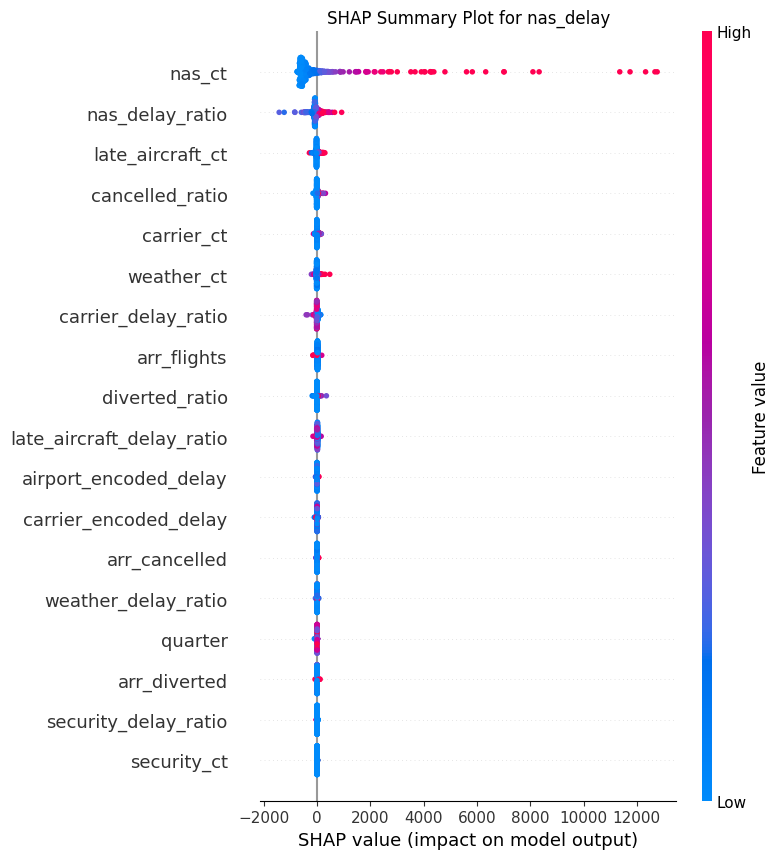

Generating SHAP summary plot for: security_delay


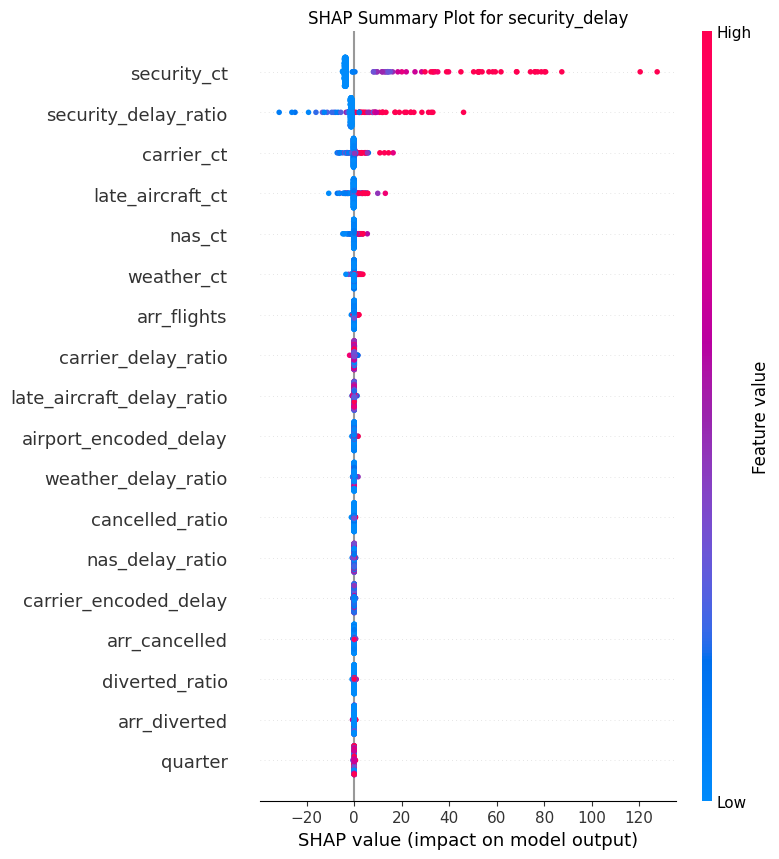

Generating SHAP summary plot for: late_aircraft_delay


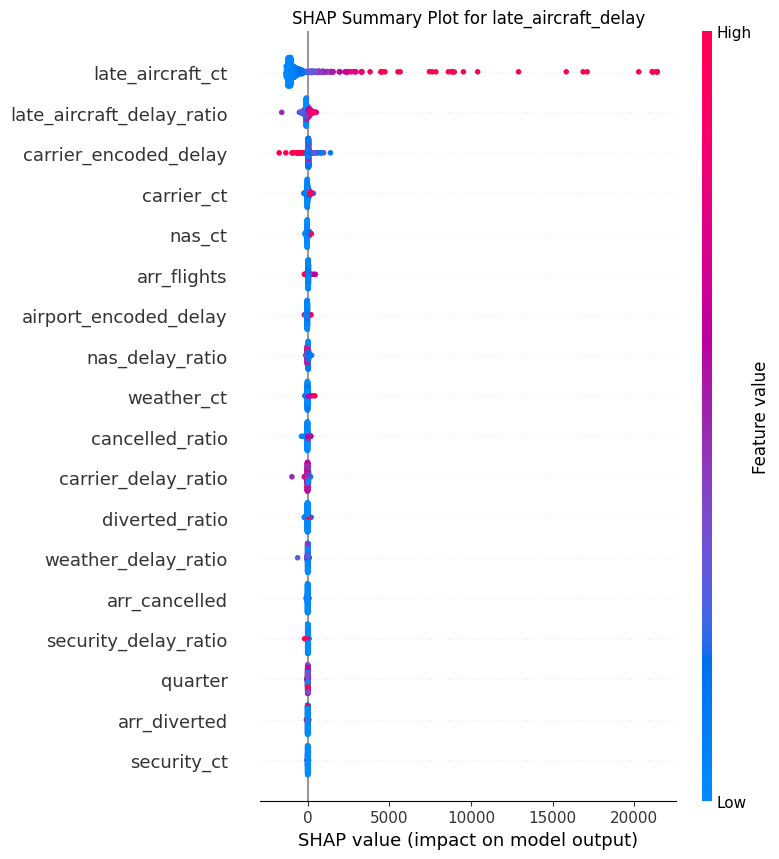

In [ ]:
# Re-use X_test_reg and y_reg_components (full original test set) for SHAP explainability
# Sample X_test_reg to manage computation time
sample_size_shap_reg = 500  # Consistent with classification SHAP
X_test_reg_sample = X_test_reg.sample(n=sample_size_shap_reg, random_state=42)

# SHAP for each output of MultiOutputRegressor
for i, delay_component in enumerate(y_reg_components.columns):
    print(f"Generating SHAP summary plot for: {delay_component}")
    # For MultiOutputRegressor, each estimator explains one output
    explainer_reg = shap.TreeExplainer(model_reg_multi.estimators_[i])
    shap_values_reg = explainer_reg(X_test_reg_sample)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_reg.values, X_test_reg_sample, show=False)
    plt.title(f'SHAP Summary Plot for {delay_component}')
    plt.tight_layout()
    plt.savefig(f'shap_summary_plot_{delay_component}.png')
    plt.show()


Cross-Validation

Classification CV

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
clf_auc_scores = []
clf_f1_scores = []

for fold, (train_index, val_index) in enumerate(tqdm(skf.split(X_clf, y_clf), total=3, desc="Classification CV")):
    X_train, X_val = X_clf.iloc[train_index], X_clf.iloc[val_index]
    y_train, y_val = y_clf.iloc[train_index], y_clf.iloc[val_index]

    model_clf_cv = RandomForestClassifier(n_estimators=30, random_state=42, class_weight='balanced', n_jobs=-1)
    model_clf_cv.fit(X_train, y_train)

    y_pred_proba_val = model_clf_cv.predict_proba(X_val)[:, 1]
    y_pred_val = model_clf_cv.predict(X_val)

    clf_auc_scores.append(roc_auc_score(y_val, y_pred_proba_val))
    clf_f1_scores.append(f1_score(y_val, y_pred_val, average='weighted'))

print(f"Classification CV AUC-ROC (mean): {np.mean(clf_auc_scores):.4f} (+/- {np.std(clf_auc_scores):.4f})")
print(f"Classification CV F1-Score (mean): {np.mean(clf_f1_scores):.4f} (+/- {np.std(clf_f1_scores):.4f})")


Classification CV: 100%|██████████| 3/3 [00:06<00:00,  2.26s/it]

Classification CV AUC-ROC (mean): 0.8968 (+/- 0.0031)
Classification CV F1-Score (mean): 0.9506 (+/- 0.0004)


Regression CV

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
reg_mae_scores = []
reg_rmse_scores = []

y_reg_total = df['arr_delay']

for fold, (train_index, val_index) in enumerate(tqdm(kf.split(X_reg, y_reg_total), total=3, desc="Regression CV")):
    X_train, X_val = X_reg.iloc[train_index], X_reg.iloc[val_index]
    y_train_comp, y_val_total = y_reg_components.iloc[train_index], y_reg_total.iloc[val_index]

    model_reg_multi_cv = MultiOutputRegressor(RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1))
    model_reg_multi_cv.fit(X_train, y_train_comp)

    y_pred_val_components = model_reg_multi_cv.predict(X_val)
    y_pred_val_total = np.sum(y_pred_val_components, axis=1)

    reg_mae_scores.append(mean_absolute_error(y_val_total, y_pred_val_total))
    reg_rmse_scores.append(np.sqrt(mean_squared_error(y_val_total, y_pred_val_total)))

print(f"Regression CV MAE (mean): {np.mean(reg_mae_scores):.2f} (+/- {np.std(reg_mae_scores):.2f})")
print(f"Regression CV RMSE (mean): {np.mean(reg_rmse_scores):.2f} (+/- {np.std(reg_rmse_scores):.2f})")


Regression CV: 100%|██████████| 3/3 [05:47<00:00, 115.93s/it]

Regression CV MAE (mean): 493.68 (+/- 4.34)
Regression CV RMSE (mean): 1340.23 (+/- 28.70)
